In [132]:
# do the necessary imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

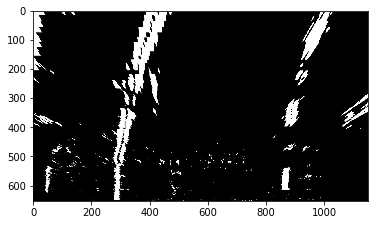

In [133]:
# read in an image
binary_warped = cv2.imread("warped_example.jpg", 0)

plt.imshow(binary_warped, cmap='gray')

In [137]:
# function to find lane pixels
def find_lane_pixels(binary_warped):
    
    # take histogram of the bottom half of the image    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    #plt.plot(histogram)
    
    # find the peak of left and right halves of the histogram. These will be the starting point of the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #np.savetxt("foo.csv", histogram[:midpoint], delimiter=",")
    
    print("Midpoint, leftx base, rightx base")
    print(midpoint, leftx_base, rightx_base)
    
    # choose number of sliding windows
    nwindows = 9
    
    # set the width of the windows +/- margin
    margin = 100
    
    # set minimum number of pixels found to recenter window
    minpix = 50
    
    # set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    #print("Window height ", window_height)
    
    # Identify the x and y positions of all non zero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # step through each windows one by one
    for window in range(nwindows):
        # identify window boundries in x and y and right and left
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = int(leftx_current - margin) 
        win_xleft_high = int(leftx_current + margin) 
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)
        
        #print(window)
        #print(win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high)
        
        # Draw windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        
        # Identify nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]
        
        # append these indices to the list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if found > minix pixels, recenter next window
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    #plt.imshow(out_img)
      
    return leftx, lefty, rightx, righty, out_img    

In [138]:
# function to fit polynomial to left and right lane pixels

def fit_polynomial(binary_warped):
    
    # find lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using np.polyfit
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate Radius of Curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    print("Radius of curvature")
    print(left_curverad, right_curverad)
    
    
    # Visualizations
    # Color in left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

Midpoint, leftx base, rightx base
575 290 875
Radius of curvature
3111.1116187 1547.78970251


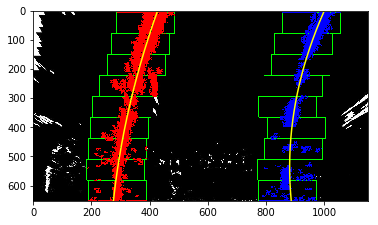

In [139]:
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)